In [1]:
%matplotlib notebook
%matplotlib notebook

In [2]:
import subprocess
import seaborn as sns

In [3]:
import sys
sys.path.append('../')
from config import configuration
config = configuration()
config.request_password()

 ·············


In [4]:
import sqlutilpy
data = pd.DataFrame(
         sqlutilpy.get('''select * from thomas_molnar.virac2_variable_sources_eaeb''',
                    **config.wsdb_kwargs)
       )

In [6]:
def get_lightcurve(sourceid):

    lcs = pd.DataFrame(sqlutilpy.get('''select sourceid, 
                                unnest(mjdobs) as mjdobs,
                                unnest(mag) as mag,
                                unnest(emag) as emag,
                                unnest(filterid) as filterid,
                                unnest(chi) as chi,
                                unnest(ast_res_chisq) as ast_res_chisq,
                                unnest(ambiguous_match) as ambiguous_match  
                                from leigh_smith.virac2_ts_tmolnar_variables where sourceid={0}'''.format(sourceid),
                     **config.wsdb_kwargs))
    
    return lcs

def get_lightcurve_bulk(sourceids):

    lcs = pd.DataFrame(sqlutilpy.get('''select sourceid, 
                                unnest(mjdobs) as mjdobs,
                                unnest(mag) as mag,
                                unnest(emag) as emag,
                                unnest(filterid) as filterid,
                                unnest(chi) as chi,
                                unnest(ast_res_chisq) as ast_res_chisq,
                                unnest(ambiguous_match) as ambiguous_match  
                                from leigh_smith.virac2_ts_tmolnar_variables where sourceid in ({0})'''.format((','.join(str(s) for s in sourceids))),
                     **config.wsdb_kwargs))
    
    return [x.reset_index(drop=True) for _, x in lcs.groupby('sourceid')]

In [8]:
def define_dataset():
    random_seed = 42
    np.random.seed(random_seed)
    start_index = 0
    classs = 'RRab'
    contaminant_percentage = 5
    duplicate_percentage = 5
    
    fltr = (data['class']==classs)
    contam_fltr = (data['class']!=classs)

    random_duplicate = np.random.randint(0,np.count_nonzero(fltr),
                                         np.int64(np.count_nonzero(fltr)*duplicate_percentage/100.))
    random_contaminant = np.random.randint(0,np.count_nonzero(contam_fltr),
                                         np.int64(np.count_nonzero(fltr)*contaminant_percentage/100.))

    dataset = pd.concat([data[fltr],
                         data[fltr].reset_index(drop=True).iloc[random_duplicate],
                         data[contam_fltr].reset_index(drop=True).iloc[random_contaminant]],axis=0).reset_index(drop=True)
    print(np.count_nonzero(fltr),len(dataset))
    return dataset

In [9]:
# output_file = 'dodgy_rrab_eaeb.txt'
dataset = define_dataset()

58377 64213


# Controls

Click and then press key

- *w* = definite contaminant
- *e* = likely contaminant
- *r* = period doubled

Without clicking can press

- *a* = previous set
- *d* = next set
- *z* = delete previously stored classification

<IPython.core.display.Javascript object>


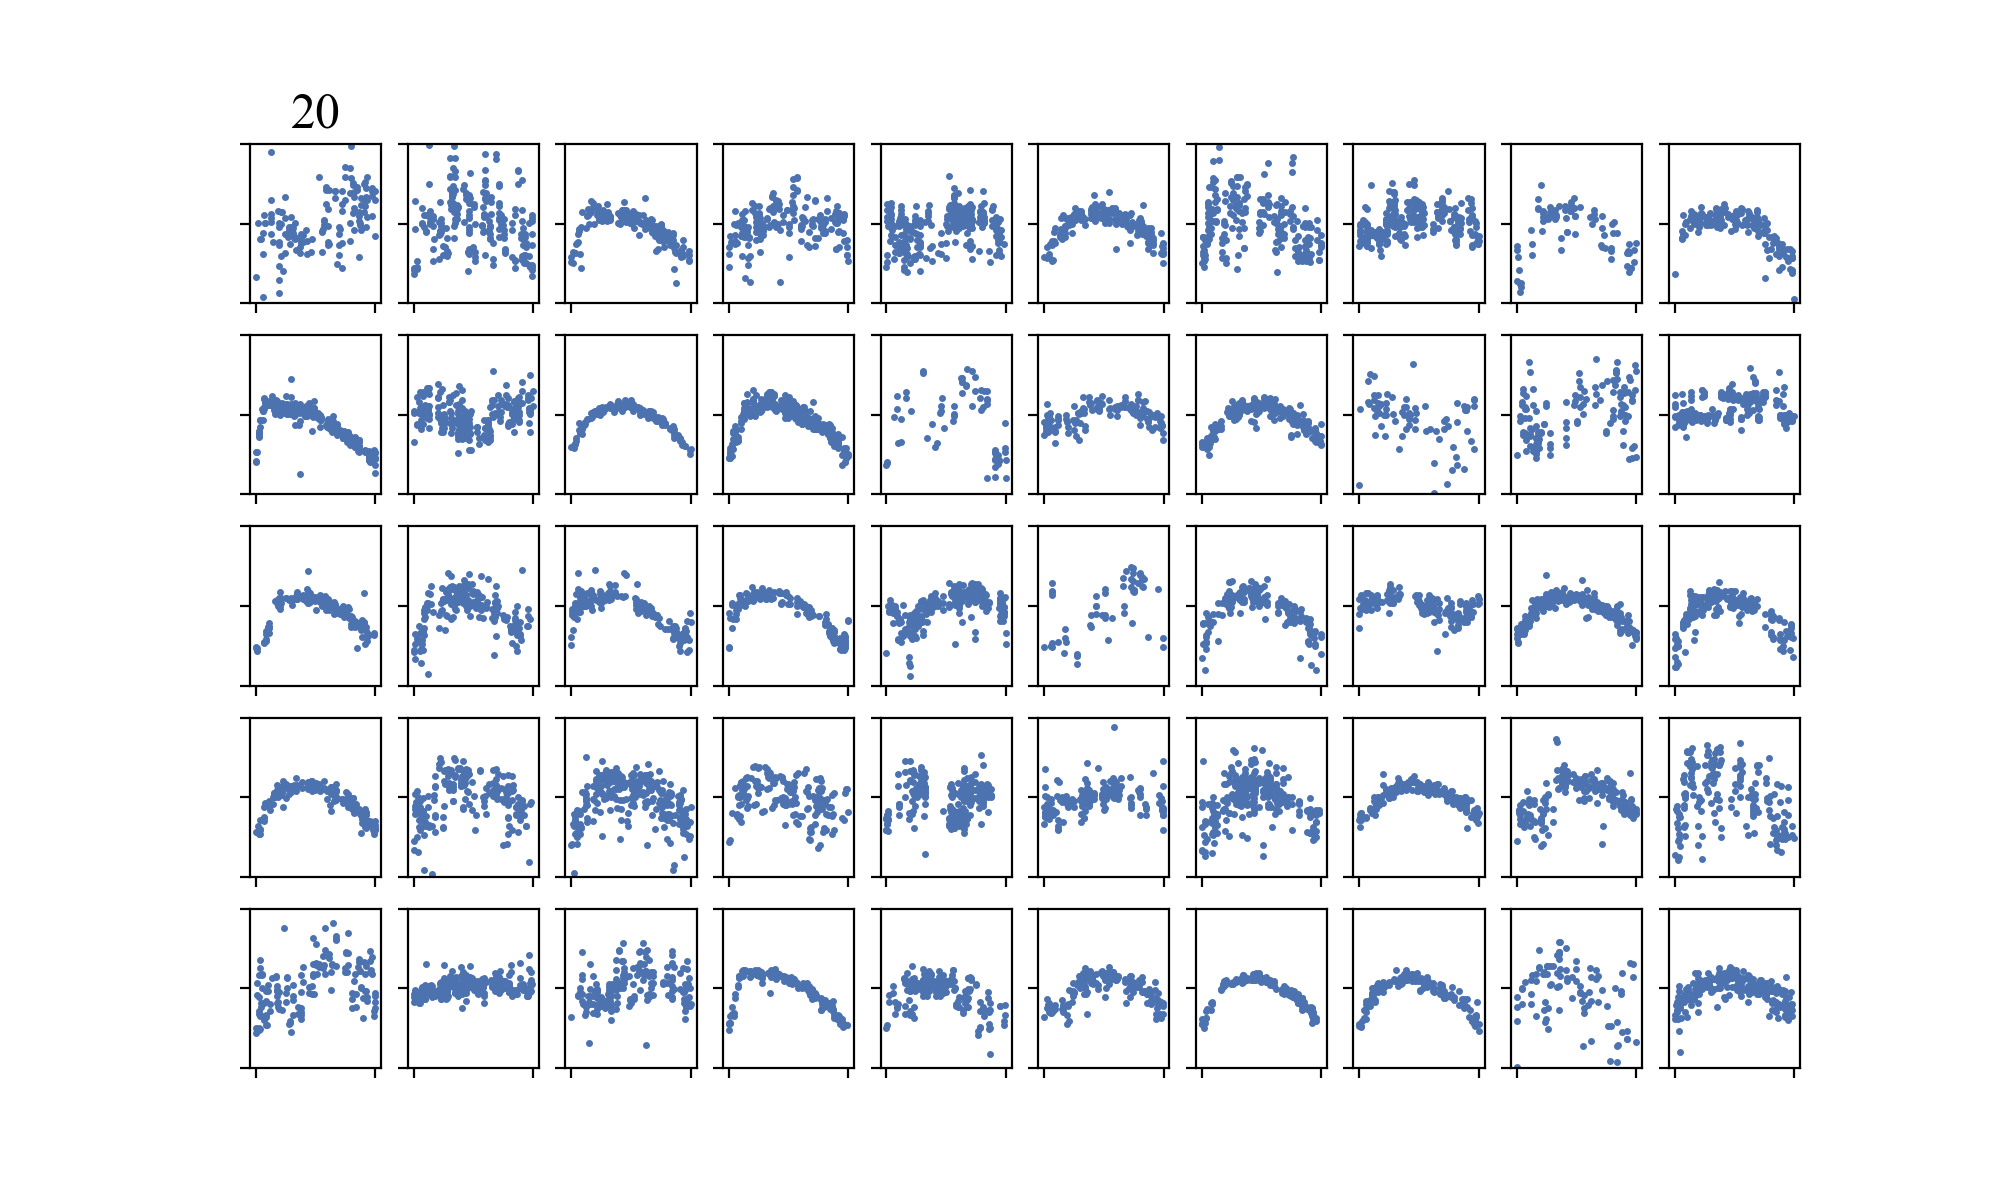

In [15]:
NY,NX=5,10
f,a=plt.subplots(NY,NX,figsize=[10,6],sharex=True,sharey=True)
a = a.flatten()

def plllt(lc,period,ax,color=sns.color_palette()[0],cla=True):
    plt.sca(ax)
    if cla:
        plt.cla()
    clean = (lc['filterid']==5)&(lc['ambiguous_match']==0)&(lc['ast_res_chisq']<13.)
    min_t = lc['mjdobs'][clean].values[np.argsort(lc['mag'][clean].values)[-5]]
    plt.plot(((lc['mjdobs'][clean]-min_t)%(period)/period),lc['mag'][clean]-np.nanmedian(lc['mag'][clean]),'.',
            ms=3,color=color)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_facecolor('white')

event_subplots={}
chunk_index=0

def plot_cl(ain):
    plt.sca(a[ain])
    plt.cla()
    
def plot_grid(chunk):
    
    s = dataset['sourceid'].values[chunk*NY*NX:(chunk+1)*NY*NX]
    p = dataset['lsq_period'].values[chunk*NY*NX:(chunk+1)*NY*NX]
    p = p[np.argsort(s)]
    s = s[np.argsort(s)]
    lcs = get_lightcurve_bulk(s)
    
    global event_subplots
    event_subplots = {ss:l for l,ss in zip(s,a[:len(s)])}
    
    [plllt(lc,pp,ax) for lc, pp, ax in zip(lcs, p, a)]
    if len(s)<len(a):
        [plot_cl(ain) for ain in range(len(s),len(a))]
        
    plt.ylim(-0.5,0.5)
    plt.sca(a[0])
    plt.title(chunk_index,fontsize=18)
    plt.gca().invert_yaxis()

import os
from functools import partial

cache=0
axis=None

def onclick(event):
    global cache
    global axis
    axis = event.inaxes
    cache = event_subplots[axis]
    
def on_press(event):
    sys.stdout.flush()
    global chunk_index
    if event.key == 'd':
        chunk_index+=1
        plot_grid(chunk_index)
    if event.key == 'a':
        chunk_index-=1
        plot_grid(chunk_index)
    elif event.key == 'w':
        with open(output_file, 'a') as w:
            w.write('%i,%s\n' % (cache,'contam'))
        axis.set_facecolor('xkcd:light salmon')
    elif event.key == 'e':
        with open(output_file, 'a') as w:
            w.write('%i,%s\n' % (cache,'likely contam'))
        axis.set_facecolor('xkcd:light rose')
    elif event.key == 'r':
        with open(output_file, 'a') as w:
            w.write('%i,%s\n' % (cache,'per double'))
        axis.set_facecolor('xkcd:light blue')
    elif event.key == 'z':
        tmp='tmp'
        with open('tmp', 'w') as t:
            subprocess.call(['head','-n','-1',output_file],stdout=t)
        subprocess.call(['mv',tmp,output_file])
        axis.set_facecolor('white')

plot_grid(0)
pid= f.canvas.mpl_connect('key_press_event', on_press)
cid = f.canvas.mpl_connect('button_press_event', onclick)

plt.show()

In [16]:
!wc -l dodgy_rrab_eaeb.txt

48 dodgy_rrab_eaeb.txt


In [5]:
ll = pd.read_csv('dodgy_rrab_eaeb.txt', names=['sourceid', 'type'])
llT = pd.read_csv('dodgy_rrab_thomas.txt', names=['sourceid', 'type'])

/data/jls/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


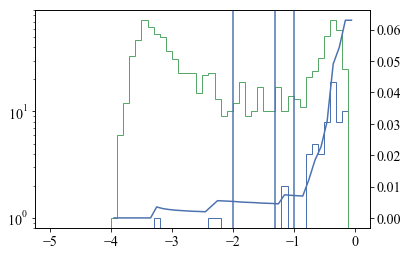

In [16]:
plt.figure()
n,b,p=plt.hist(np.log10(1-dataset['prob'][np.isin(dataset['sourceid'], 
                                                  ll['sourceid'][ll['type']!='per double'])]),
         histtype='step',bins=50,range=[-5,0]);

# n3,b,p=plt.hist(np.log10(1-dataset['prob'][np.isin(dataset['sourceid'], llT['sourceid'][llT['type']!='per double'])]),
#          histtype='step',bins=50,range=[-5,0]);


n2,b,p=plt.hist(np.log10(1-dataset['prob'][:20*50]),histtype='step',bins=50,range=[-5,0]);


plt.semilogy()
plt.twinx()
plt.plot(.5*(b[1:]+b[:-1]),np.cumsum(n)/np.cumsum(n2))
# plt.plot(.5*(b[1:]+b[:-1]),np.cumsum(n)/np.cumsum(n3))
plt.axvline(np.log10(0.1))
plt.axvline(np.log10(0.05))
plt.axvline(np.log10(0.01))

In [19]:
np.savetxt('mis_class.dat',np.vstack([.5*(b[1:]+b[:-1]),np.cumsum(n)/(1.*np.cumsum(n2))]).T)

/data/jls/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


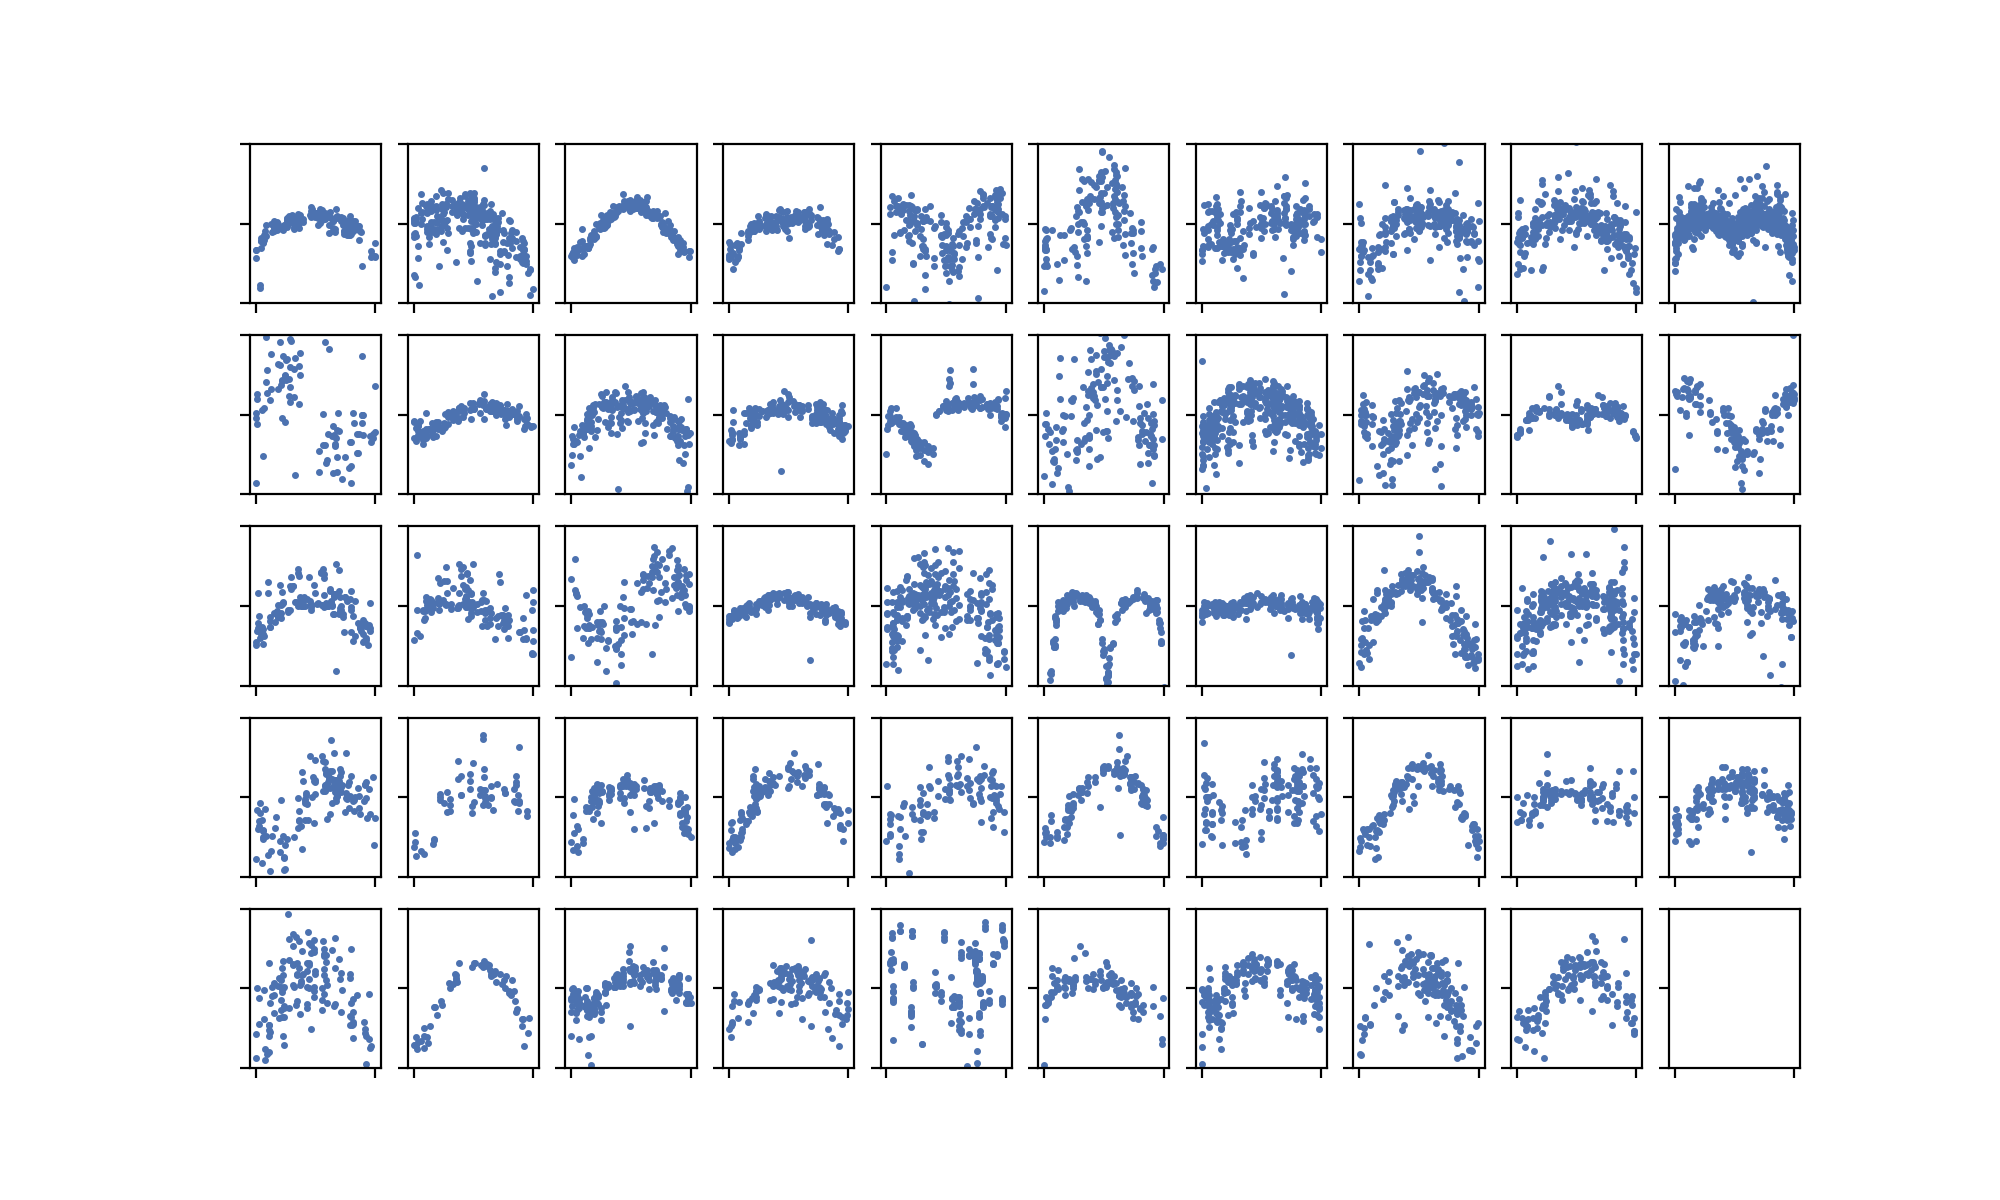

(0.5, -0.5)

In [122]:
fll=dataset[np.isin(dataset['sourceid'].values, llT['sourceid'].values[llT['type']!='per double'])][
    ['sourceid', 'prob', 'lsq_period']].sort_values('prob')[::-1].reset_index(drop=True).iloc[:50]
fll = fll[~fll.duplicated()].reset_index(drop=True)


f,a=plt.subplots(5,10,figsize=[10,6],sharex=True,sharey=True)
a=a.flatten()
s = fll['sourceid'].values
p = fll['lsq_period'].values
p = p[np.argsort(s)]
s = s[np.argsort(s)]
    
lcs = get_lightcurve_bulk(s)
[plllt(lc,pp,ax) for lc, pp, ax in zip(lcs, p, a)]
plt.gca().invert_yaxis()
plt.gca().set_ylim(0.5,-0.5)

<IPython.core.display.Javascript object>


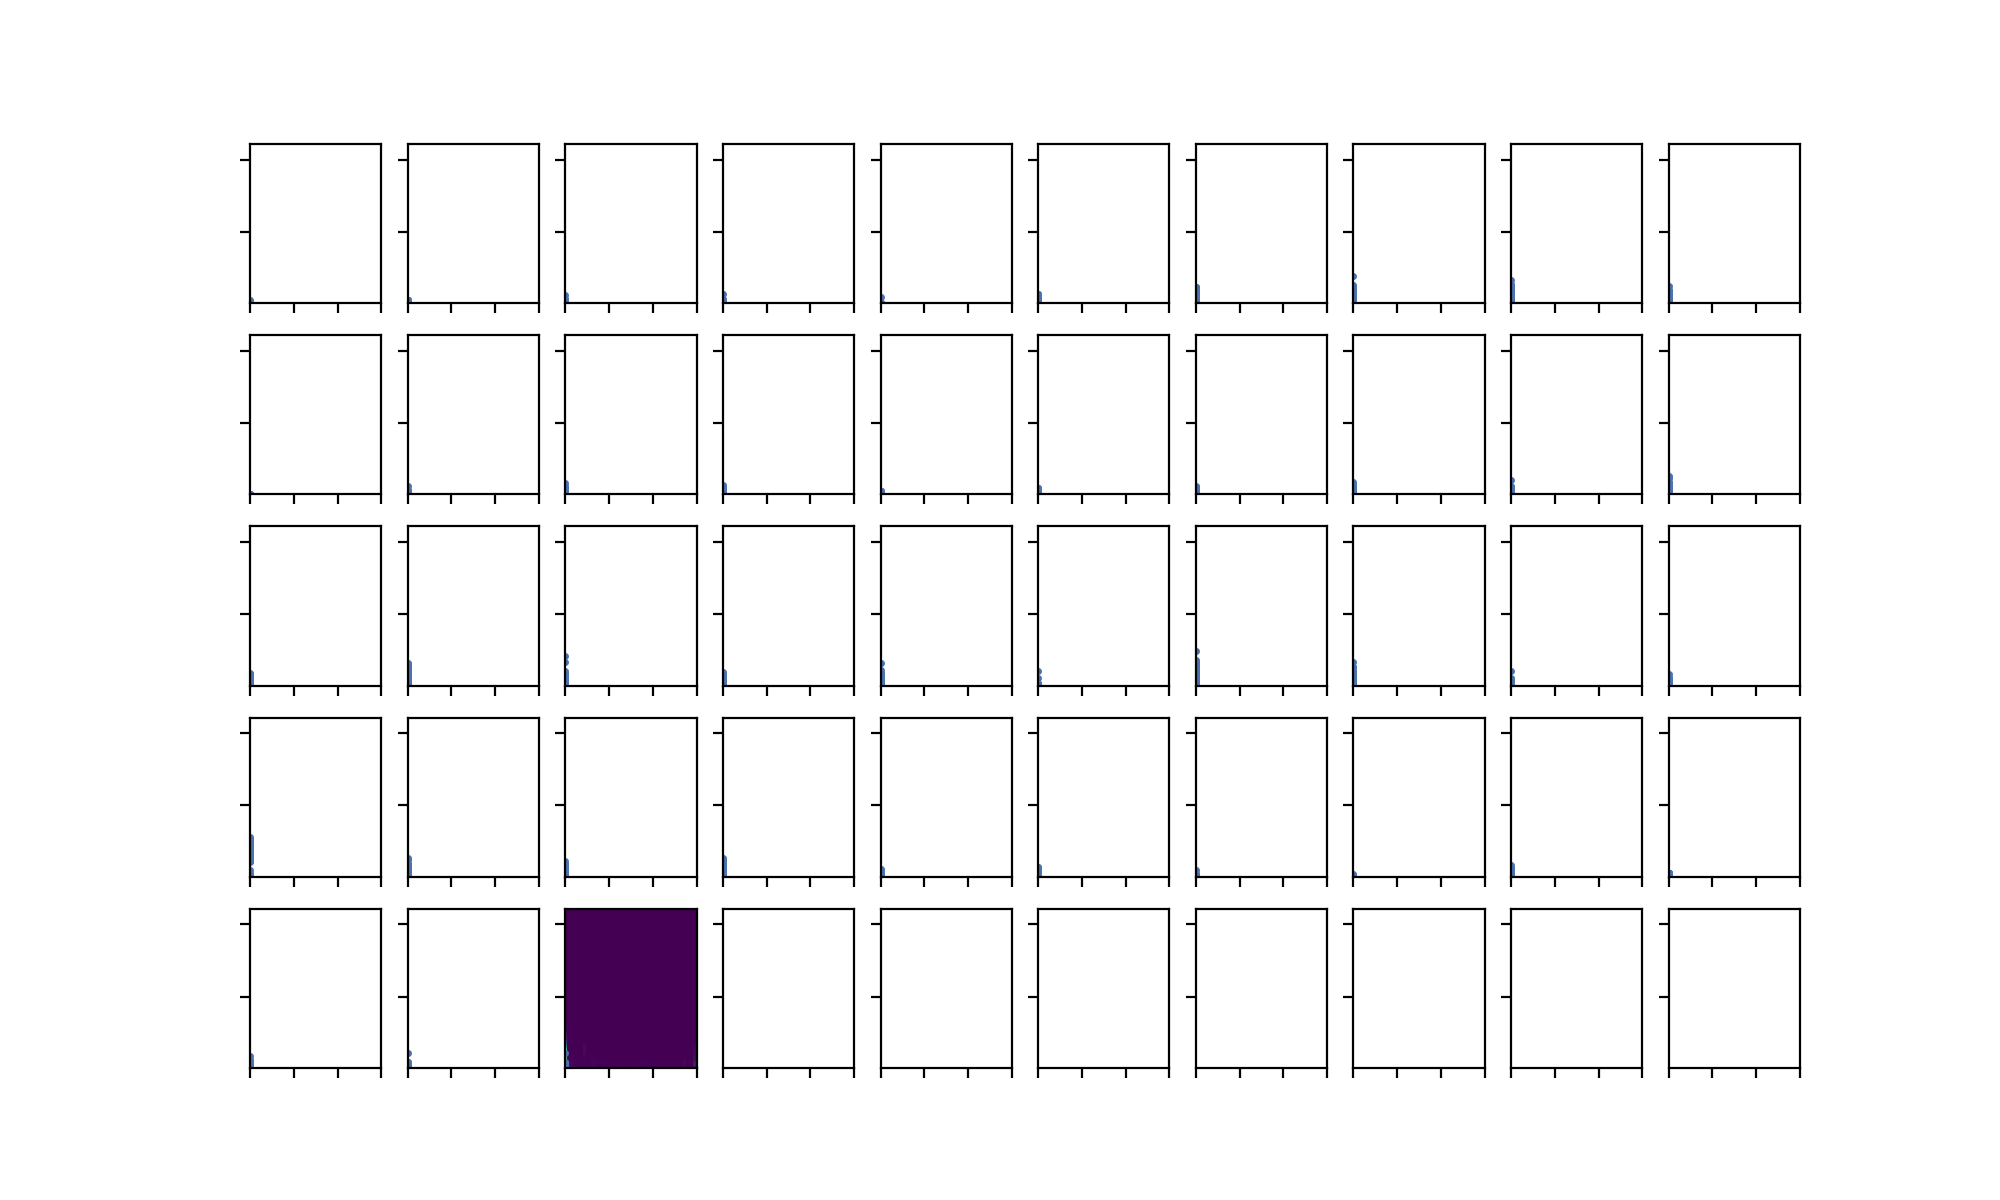

(0.5, -0.5)

In [21]:
fll=dataset[np.isin(dataset['sourceid'].values, ll['sourceid'].values[ll['type']!='per double'])][
    ['sourceid', 'prob', 'lsq_period']].sort_values('prob')[::-1].reset_index(drop=True).iloc[:50]
fll = fll[~fll.duplicated()].reset_index(drop=True)

f,a=plt.subplots(5,10,figsize=[10,6],sharex=True,sharey=True)
a=a.flatten()
s = fll['sourceid'].values
p = fll['lsq_period'].values
p = p[np.argsort(s)]
s = s[np.argsort(s)]
    
lcs = get_lightcurve_bulk(s)
[plllt(lc,pp,ax) for lc, pp, ax in zip(lcs, p, a)]
plt.gca().invert_yaxis()
plt.gca().set_ylim(0.5,-0.5)

In [125]:
import sys
sys.path.append('../')

import pickle

with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_classifier.pkl', 'rb') as f:
    var = pickle.load(f)
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_training_set.pkl', 'rb') as f:
    var_dataset_scaled = pickle.load(f)
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_features_total.pkl', 'rb') as f:
    var_dataset_full = pickle.load(f)
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_features_mira.pkl', 'rb') as f:
    mira_features = pickle.load(f)
var_dataset_full = pd.concat([var_dataset_full, mira_features], axis=0)
var_dataset = var_dataset_full.merge(var_dataset_scaled[['sourceid', 'class', 'prob']], on='sourceid')
var_dataset_full = var_dataset_full[(~var_dataset_full['error'])].reset_index(drop=True)

/home/jls/.local/lib/python3.5/site-packages/xgboost/__init__.py:29: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)
/data/jls/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


<IPython.core.display.Javascript object>


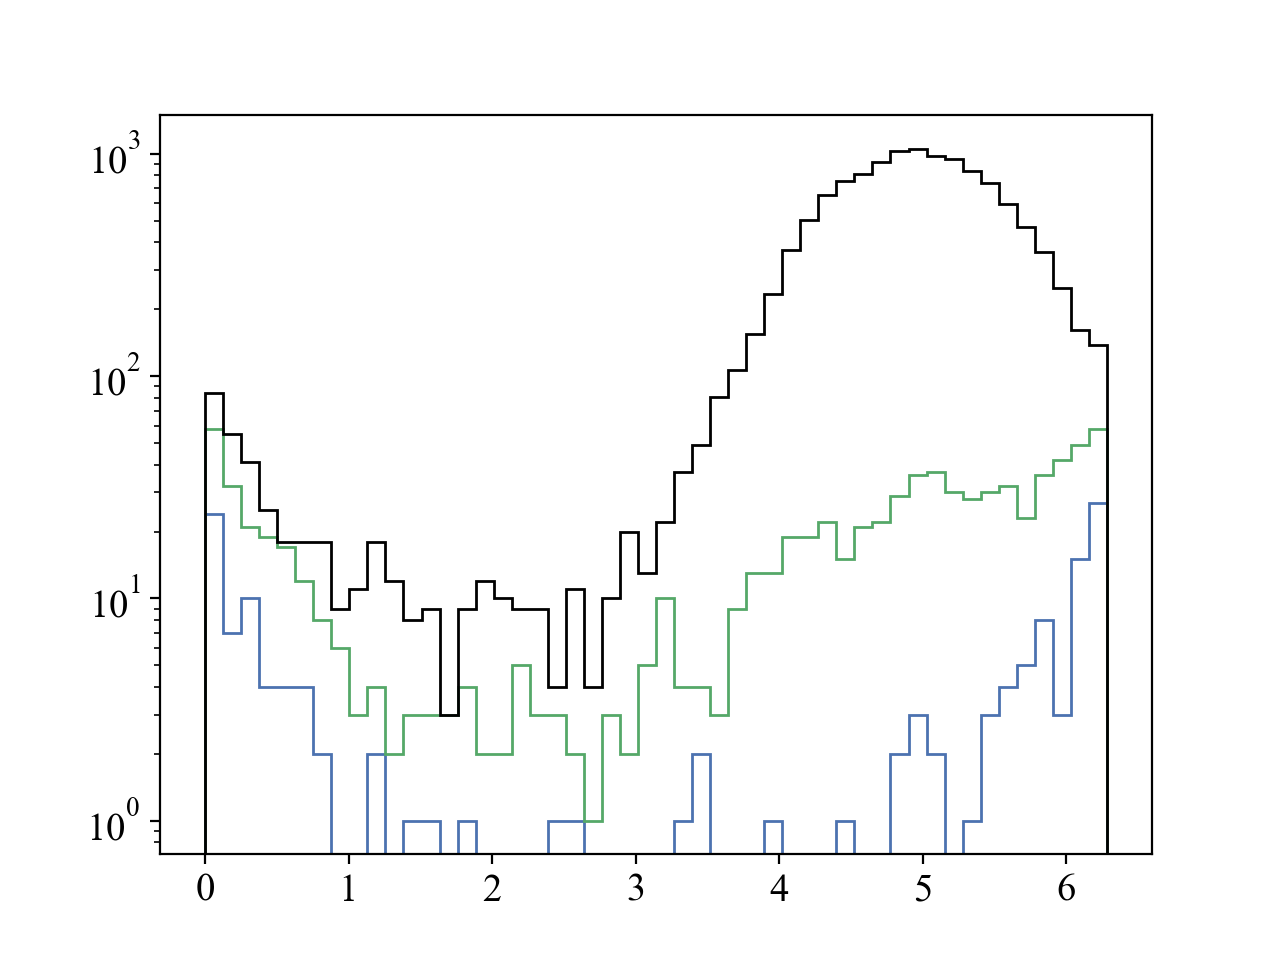

[]

In [171]:
plt.figure()
# plt.hist(var_dataset_full['phi2_phi0'][(var_dataset_full['var_class']=='RRab')&(var_dataset['prob']>0.9)],bins=50);

# plt.hist(var_dataset_full['phi2_phi0'][(var_dataset_full['var_class']=='EA/EB')],
#          bins=50,histtype='step');

# plt.hist(var_dataset_full['phi2_phi0'][(var_dataset_full['var_class']=='EW')],
#          bins=50,histtype='step');


n,b,p=plt.hist((dataset['phi_2']-3*dataset['phi_0'])[np.isin(dataset['sourceid'], 
                                                             ll['sourceid'][ll['type']!='per double'])],
         histtype='step',bins=50,range=[0,2*np.pi]);
n2,b,p=plt.hist((dataset['phi_2']-3*dataset['phi_0'])[:50*50],histtype='step',bins=50,range=[0,2*np.pi]);
n2,b,p=plt.hist((dataset['phi_2']-3*dataset['phi_0'])[(dataset['prob']>0.99)&(dataset['ks_ivw_mean_mag']<17.)],histtype='step',bins=50,
                range=[0,2*np.pi],color='k');
plt.semilogy()

In [291]:
np.count_nonzero(var_dataset_full[
    np.isin(var_dataset_full['sourceid'].values, ll['sourceid'][ll['type']!='per double'])]['log10_fap'].values<-10)

57

In [289]:
np.count_nonzero(~var_dataset_full[
    np.isin(var_dataset_full['sourceid'].values, ll['sourceid'][ll['type']!='per double'])]['significant_second_minimum'].values)

51

<IPython.core.display.Javascript object>


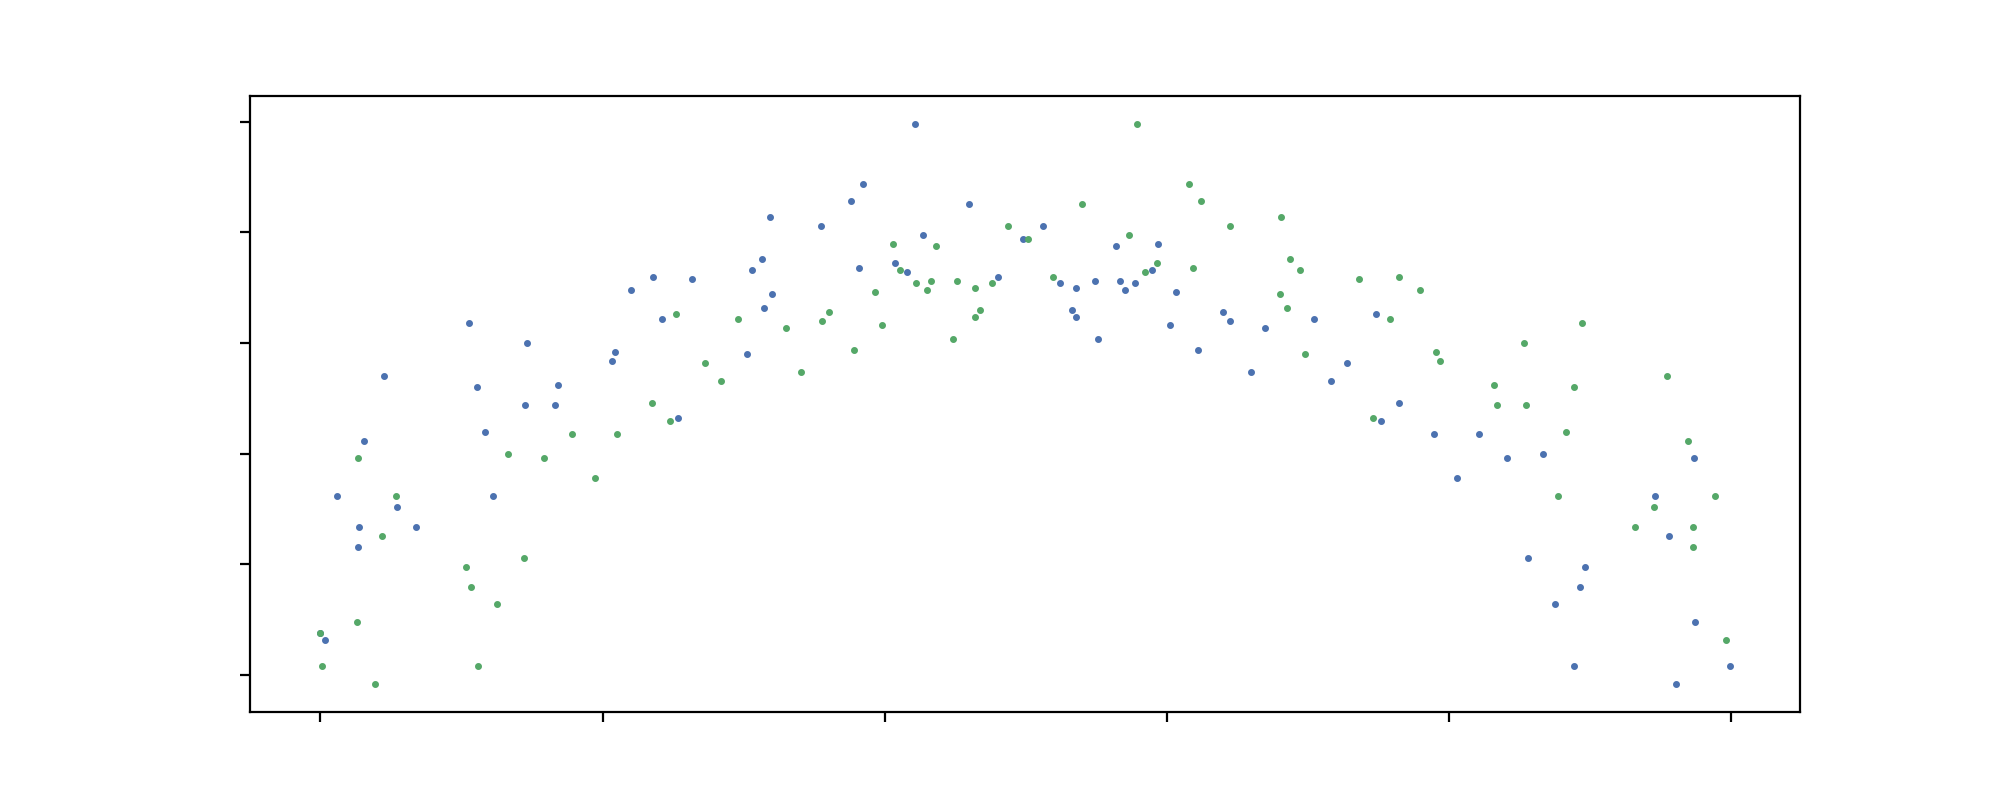

In [287]:
pp=var_dataset_full[['sourceid','lsq_period']][
    (var_dataset_full['var_class']=='EW')
    &(var_dataset_full['significant_second_minimum']==0)
    &(var_dataset['class']=='RRab')
    &(var_dataset['prob']>0.99)].reset_index(drop=True)

pp=var_dataset_full[['sourceid', 'lsq_period', 'var_class', 'significant_second_minimum']].reset_index(drop=True)
# [
# #     ~np.isin(var_dataset_full['sourceid'].values, ll['sourceid'][ll['type']!='per double'])
# ]

pp = pp[(pp['var_class']=='EA/EB')&(pp['significant_second_minimum']==0)].reset_index(drop=True)
ff = plt.figure(figsize=[10.,4.])
ii=30
lc = get_lightcurve(pp['sourceid'].values[ii])
plllt(lc,pp['lsq_period'].values[ii],plt.gca(),color=sns.color_palette()[0])
lc['mjdobs']=np.max(lc['mjdobs'])-lc['mjdobs']
plllt(lc,pp['lsq_period'].values[ii],plt.gca(),color=sns.color_palette()[1],cla=False)
plt.gca().invert_yaxis()

In [246]:
lc.columns

Index(['sourceid', 'mjdobs', 'mag', 'emag', 'filterid', 'chi', 'ast_res_chisq',
       'ambiguous_match'],
      dtype='object')

<IPython.core.display.Javascript object>


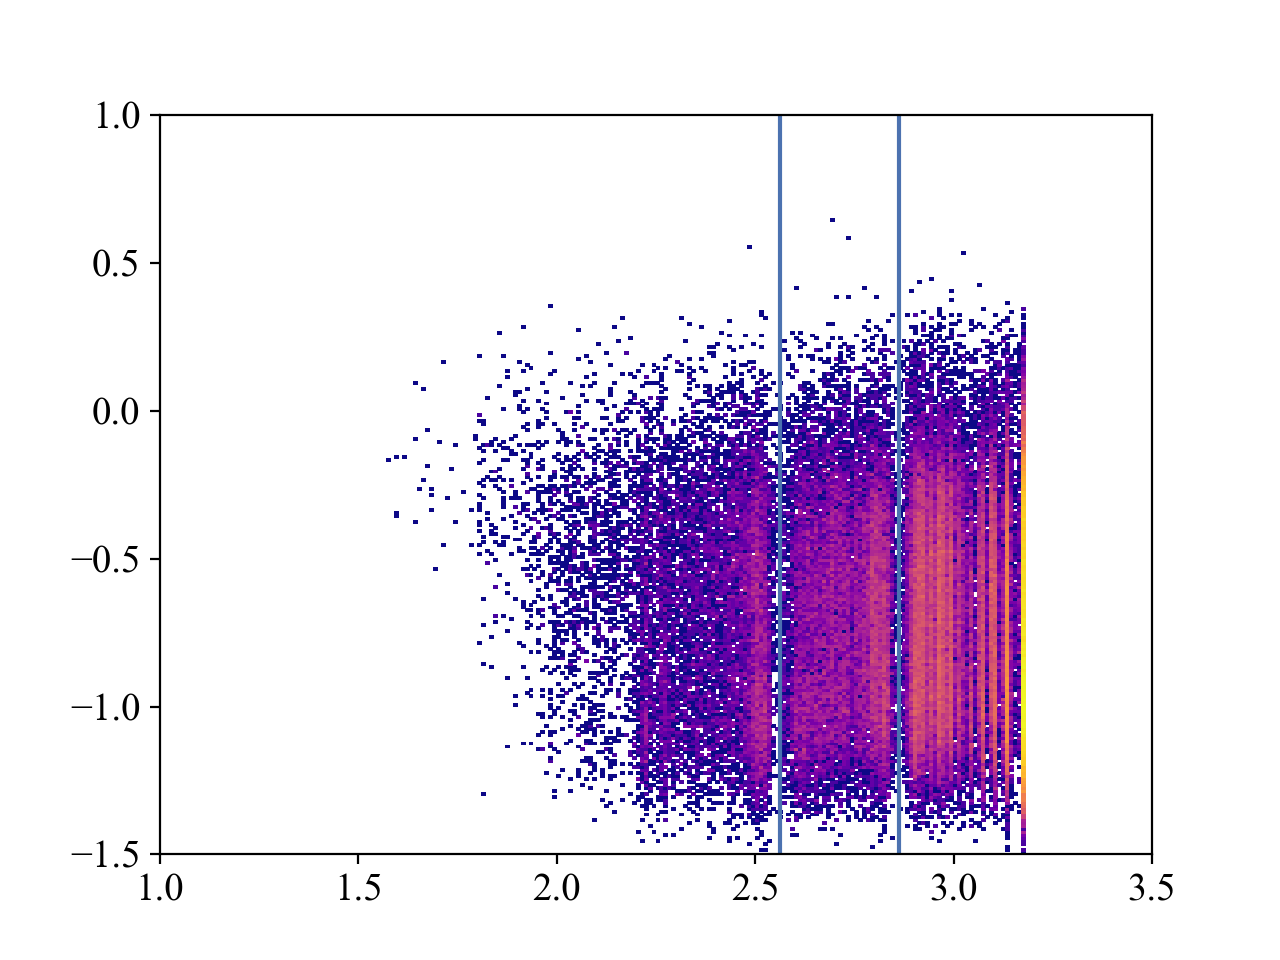

In [108]:
plt.figure()


from matplotlib.colors import LogNorm
# plt.hist2d(np.log10(data['lsq_period'][(data['prob']>0.9)&(data['class']=='EA/EB')]),
#            np.log10(data['amplitude'][(data['prob']>0.9)&(data['class']=='EA/EB')]),bins=250,norm=LogNorm(),
#            cmap=plt.cm.plasma,
#           range=[[-1,0.5],[-1.5,0.]]);
from matplotlib.colors import LogNorm
plt.hist2d(np.log10(data['lsq_period'][(data['prob']>0.9)&(data['class']=='EW')]),
           np.log10(data['amplitude'][(data['prob']>0.9)&(data['class']=='EW')]),
           bins=250,norm=LogNorm(),
          range=[[-1.,0.5],[-1.5,1.]]);


plt.hist2d(np.log10(data['lsq_period'][(data['prob']>0.99)&(data['class']=='LPV')]),
           np.log10(data['amplitude'][(data['prob']>0.99)&(data['class']=='LPV')]),
           bins=250,norm=LogNorm(),
          range=[[1.,3.5],[-1.5,1.]],cmap=plt.cm.plasma);
# plt.plot(np.log10(fll['lsq_period']), np.log10(fll['amplitude']), 'ro');
# plt.figure()
plt.axvline(np.log10(365.))
plt.axvline(np.log10(365.*2.))

In [78]:
fll=dataset[np.isin(dataset['sourceid'].values, ll['sourceid'].values[ll['type']=='per double'])][
    ['sourceid', 'prob', 'lsq_period', 'amplitude']].sort_values('prob')[::-1].reset_index(drop=True)
fll = fll[~fll.duplicated()].reset_index(drop=True)